# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [2]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [3]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=30, batch_size=30)

Metal device set to: Apple M1
Epoch 1/30


2022-12-01 15:07:47.015698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 15:07:47.016009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-01 15:07:47.203976: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/60 [..............................] - ETA: 24s - loss: 2.2644 - accuracy: 0.4667

2022-12-01 15:07:47.453842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 1s 9ms/step - loss: 0.7817 - accuracy: 0.6617
Epoch 2/30
60/60 [==============================] - 1s 9ms/step - loss: 0.3853 - accuracy: 0.8353
Epoch 3/30
60/60 [==============================] - 1s 10ms/step - loss: 0.2881 - accuracy: 0.8876
Epoch 4/30
60/60 [==============================] - 1s 9ms/step - loss: 0.2472 - accuracy: 0.8987
Epoch 5/30
60/60 [==============================] - 1s 10ms/step - loss: 0.2122 - accuracy: 0.9171
Epoch 6/30
60/60 [==============================] - 1s 9ms/step - loss: 0.1918 - accuracy: 0.9232
Epoch 7/30
60/60 [==============================] - 1s 10ms/step - loss: 0.1696 - accuracy: 0.9366
Epoch 8/30
60/60 [==============================] - 1s 9ms/step - loss: 0.1502 - accuracy: 0.9399
Epoch 9/30
60/60 [==============================] - 1s 9ms/step - loss: 0.1378 - accuracy: 0.9482
Epoch 10/30
60/60 [==============================] - 1s 9ms/step - loss: 0.1234 - accuracy: 0.9549
Epoch 11/30
60/60 [========

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [4]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

In [5]:
X_pure_train.shape

(1149, 64)

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [6]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
 8/12 [===================>..........] - ETA: 0s - loss: 0.7335 - accuracy: 0.5000

2022-12-01 15:12:16.757954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 11ms/step - loss: 0.7337 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 9ms/step - loss: 0.7252 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 9ms/step - loss: 0.7185 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 7ms/step - loss: 0.7137 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 8ms/step - loss: 0.7096 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 8ms/step - loss: 0.7064 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 9ms/step - loss: 0.7039 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 9ms/step - loss: 0.7018 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 12ms/step - loss: 0.7004 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 7ms/step - loss: 0.6991 - accuracy: 0.4961


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [8]:
results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x280e01580>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7337338924407959,
   0.7252453565597534,
   0.7185274362564087,
   0.7136576175689697,
   0.7096322774887085,
   0.7064158320426941,
   0.7039496302604675,
   0.7018485069274902,
   0.7004148960113525,
   0.6991204619407654],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

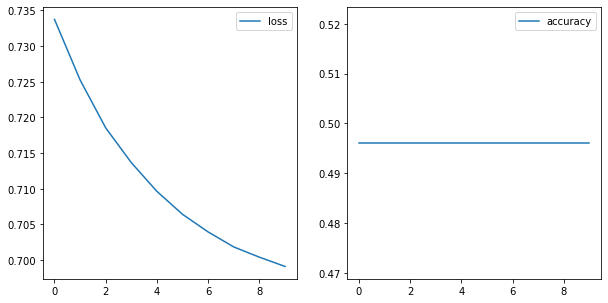

In [9]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [11]:
X_pure_train.shape

(1149, 64)

In [16]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=50, verbose=1)

Epoch 1/100
14/23 [=================>............] - ETA: 0s - loss: 0.7406 - accuracy: 0.4657

2022-12-01 15:18:06.496944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 10ms/step - loss: 0.7179 - accuracy: 0.4865
Epoch 2/100
23/23 [==============================] - 0s 8ms/step - loss: 0.6689 - accuracy: 0.5483
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 0.6490 - accuracy: 0.6536
Epoch 4/100
23/23 [==============================] - 0s 8ms/step - loss: 0.6337 - accuracy: 0.6928
Epoch 5/100
23/23 [==============================] - 0s 10ms/step - loss: 0.6189 - accuracy: 0.7163
Epoch 6/100
23/23 [==============================] - 0s 9ms/step - loss: 0.6037 - accuracy: 0.7232
Epoch 7/100
23/23 [==============================] - 0s 8ms/step - loss: 0.5883 - accuracy: 0.7337
Epoch 8/100
23/23 [==============================] - 0s 8ms/step - loss: 0.5726 - accuracy: 0.7450
Epoch 9/100
23/23 [==============================] - 0s 8ms/step - loss: 0.5560 - accuracy: 0.7589
Epoch 10/100
23/23 [==============================] - 0s 7ms/step - loss: 0.5398 - accuracy: 0.7746
Epoch 11/100
23/23 

23/23 [==============================] - 0s 7ms/step - loss: 0.1742 - accuracy: 0.9243
Epoch 84/100
23/23 [==============================] - 0s 10ms/step - loss: 0.1725 - accuracy: 0.9260
Epoch 85/100
23/23 [==============================] - 0s 8ms/step - loss: 0.1715 - accuracy: 0.9269
Epoch 86/100
23/23 [==============================] - 0s 8ms/step - loss: 0.1701 - accuracy: 0.9260
Epoch 87/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1692 - accuracy: 0.9286
Epoch 88/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1679 - accuracy: 0.9278
Epoch 89/100
23/23 [==============================] - 0s 8ms/step - loss: 0.1662 - accuracy: 0.9278
Epoch 90/100
23/23 [==============================] - 0s 8ms/step - loss: 0.1651 - accuracy: 0.9286
Epoch 91/100
23/23 [==============================] - 0s 8ms/step - loss: 0.1643 - accuracy: 0.9312
Epoch 92/100
23/23 [==============================] - 0s 7ms/step - loss: 0.1630 - accuracy: 0.9347
Epoch 93/100

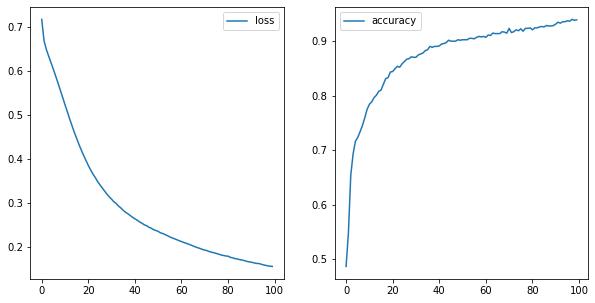

In [17]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
  7/115 [>.............................] - ETA: 0s - loss: 479.3051 - accuracy: 0.4429

2022-12-01 15:20:56.305383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 1s 8ms/step - loss: 30.2166 - accuracy: 0.4795
Epoch 2/30
115/115 [==============================] - 1s 8ms/step - loss: 1.1273 - accuracy: 0.4726
Epoch 3/30
115/115 [==============================] - 1s 7ms/step - loss: 0.9225 - accuracy: 0.5065
Epoch 4/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0998 - accuracy: 0.4891
Epoch 5/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0321 - accuracy: 0.4952
Epoch 6/30
115/115 [==============================] - 1s 7ms/step - loss: 0.9609 - accuracy: 0.5100
Epoch 7/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0077 - accuracy: 0.5030
Epoch 8/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0398 - accuracy: 0.4830
Epoch 9/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0873 - accuracy: 0.4822
Epoch 10/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0169 - accuracy: 0.4970
Epoch 11/

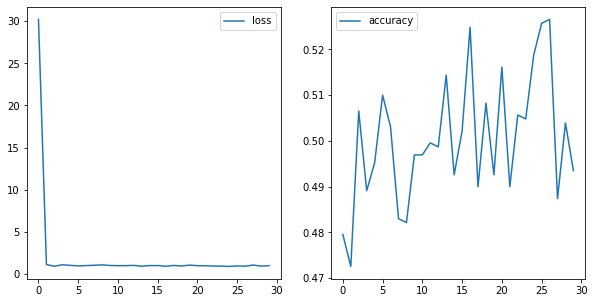

In [18]:
model = Sequential()

sgd = SGD(learning_rate=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
  7/115 [>.............................] - ETA: 0s - loss: 0.7828 - accuracy: 0.3857 

2022-12-01 15:26:24.338663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 2s 12ms/step - loss: 0.6364 - accuracy: 0.6432 - val_loss: 0.5455 - val_accuracy: 0.7604
Epoch 2/30
  1/115 [..............................] - ETA: 1s - loss: 0.5354 - accuracy: 0.8000

2022-12-01 15:26:25.620062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 1s 10ms/step - loss: 0.4238 - accuracy: 0.8468 - val_loss: 0.3578 - val_accuracy: 0.8889
Epoch 3/30
115/115 [==============================] - 1s 10ms/step - loss: 0.2956 - accuracy: 0.8834 - val_loss: 0.2746 - val_accuracy: 0.8854
Epoch 4/30
115/115 [==============================] - 1s 10ms/step - loss: 0.2450 - accuracy: 0.9008 - val_loss: 0.2276 - val_accuracy: 0.9028
Epoch 5/30
115/115 [==============================] - 1s 10ms/step - loss: 0.2088 - accuracy: 0.9164 - val_loss: 0.2115 - val_accuracy: 0.9271
Epoch 6/30
115/115 [==============================] - 1s 10ms/step - loss: 0.1861 - accuracy: 0.9286 - val_loss: 0.1744 - val_accuracy: 0.9479
Epoch 7/30
115/115 [==============================] - 1s 9ms/step - loss: 0.1591 - accuracy: 0.9373 - val_loss: 0.1719 - val_accuracy: 0.9444
Epoch 8/30
115/115 [==============================] - 1s 9ms/step - loss: 0.1404 - accuracy: 0.9399 - val_loss: 0.1740 - val_accuracy: 0.9271
Epoch 9/30
1

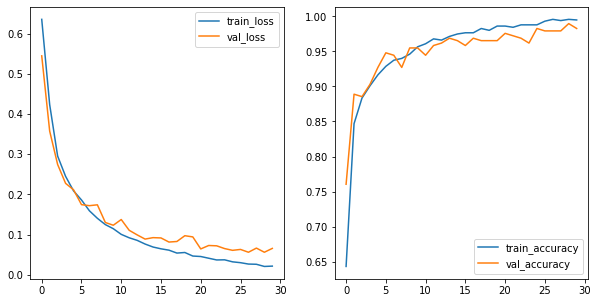

In [19]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train, epochs=30, batch_size=10, verbose=1,
                   validation_data=(X_val, y_val))


train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [20]:
results.history['val_accuracy'][-1]

0.9826388955116272

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [21]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x280e3ddf0> does not.

In [22]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [23]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=1)

/var/folders/0c/wkrr_xjn2xz65fx41rj45h6w0000gp/T/ipykernel_11260/2453450268.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = scikit_learn.KerasClassifier(build_model,


In [24]:
type(keras_model)

keras.wrappers.scikit_learn.KerasClassifier

In [26]:
cross_val_score(keras_model, X_pure_train, y_pure_train, cv=3)

Epoch 1/50
 7/24 [=======>......................] - ETA: 0s - loss: 0.7515 - accuracy: 0.4107

2022-12-01 15:34:42.111913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 1s 11ms/step - loss: 0.7120 - accuracy: 0.5078
Epoch 2/50
24/24 [==============================] - 0s 8ms/step - loss: 0.6427 - accuracy: 0.6397
Epoch 3/50
24/24 [==============================] - 0s 9ms/step - loss: 0.5966 - accuracy: 0.7089
Epoch 4/50
24/24 [==============================] - 0s 10ms/step - loss: 0.5417 - accuracy: 0.7559
Epoch 5/50
24/24 [==============================] - 0s 9ms/step - loss: 0.4766 - accuracy: 0.8290
Epoch 6/50
24/24 [==============================] - 0s 8ms/step - loss: 0.4093 - accuracy: 0.8512
Epoch 7/50
24/24 [==============================] - 0s 8ms/step - loss: 0.3482 - accuracy: 0.8760
Epoch 8/50
24/24 [==============================] - 0s 9ms/step - loss: 0.3097 - accuracy: 0.8668
Epoch 9/50
24/24 [==============================] - 0s 8ms/step - loss: 0.2729 - accuracy: 0.8982
Epoch 10/50
24/24 [==============================] - 0s 8ms/step - loss: 0.2471 - accuracy: 0.8995
Epoch 11/50
24/24 [=========

2022-12-01 15:34:53.206125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50
 7/24 [=======>......................] - ETA: 0s - loss: 0.7520 - accuracy: 0.3884

2022-12-01 15:34:53.602291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 1s 10ms/step - loss: 0.7151 - accuracy: 0.4765
Epoch 2/50
24/24 [==============================] - 0s 9ms/step - loss: 0.6463 - accuracy: 0.6201
Epoch 3/50
24/24 [==============================] - 0s 8ms/step - loss: 0.6081 - accuracy: 0.6802
Epoch 4/50
24/24 [==============================] - 0s 8ms/step - loss: 0.5676 - accuracy: 0.7454
Epoch 5/50
24/24 [==============================] - 0s 9ms/step - loss: 0.5129 - accuracy: 0.7833
Epoch 6/50
24/24 [==============================] - 0s 8ms/step - loss: 0.4528 - accuracy: 0.8264
Epoch 7/50
24/24 [==============================] - 0s 8ms/step - loss: 0.3937 - accuracy: 0.8460
Epoch 8/50
24/24 [==============================] - 0s 8ms/step - loss: 0.3417 - accuracy: 0.8551
Epoch 9/50
24/24 [==============================] - 0s 8ms/step - loss: 0.3074 - accuracy: 0.8747
Epoch 10/50
24/24 [==============================] - 0s 7ms/step - loss: 0.2810 - accuracy: 0.8786
Epoch 11/50
24/24 [==========

2022-12-01 15:35:03.935071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50
 6/24 [======>.......................] - ETA: 0s - loss: 0.7338 - accuracy: 0.4375

2022-12-01 15:35:04.354920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 1s 11ms/step - loss: 0.7149 - accuracy: 0.4987
Epoch 2/50
24/24 [==============================] - 0s 8ms/step - loss: 0.6420 - accuracy: 0.6593
Epoch 3/50
24/24 [==============================] - 0s 10ms/step - loss: 0.5844 - accuracy: 0.7206
Epoch 4/50
24/24 [==============================] - 0s 9ms/step - loss: 0.5186 - accuracy: 0.7911
Epoch 5/50
24/24 [==============================] - 0s 8ms/step - loss: 0.4448 - accuracy: 0.8355
Epoch 6/50
24/24 [==============================] - 0s 9ms/step - loss: 0.3801 - accuracy: 0.8473
Epoch 7/50
24/24 [==============================] - 0s 8ms/step - loss: 0.3271 - accuracy: 0.8812
Epoch 8/50
24/24 [==============================] - 0s 9ms/step - loss: 0.2948 - accuracy: 0.8851
Epoch 9/50
24/24 [==============================] - 0s 9ms/step - loss: 0.2675 - accuracy: 0.8903
Epoch 10/50
24/24 [==============================] - 0s 9ms/step - loss: 0.2510 - accuracy: 0.8956
Epoch 11/50
24/24 [=========

2022-12-01 15:35:15.248324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([0.95300263, 0.95300263, 0.96083552])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

2022-12-01 15:39:06.222125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-01 15:39:06.891321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


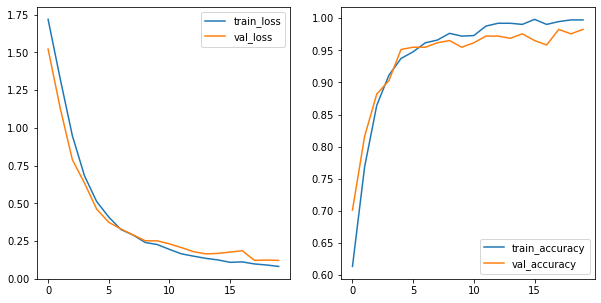

In [27]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu', kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

2022-12-01 15:40:25.020912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-01 15:40:25.704416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


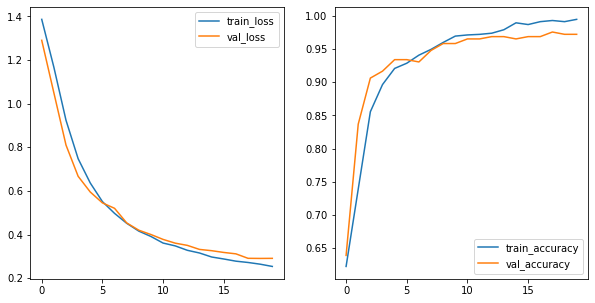

In [28]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

Epoch 1/50
 1/36 [..............................] - ETA: 15s - loss: 0.7878 - accuracy: 0.5938

2022-12-01 15:44:15.720665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 19ms/step - loss: 0.7266 - accuracy: 0.5039 - val_loss: 0.6892 - val_accuracy: 0.5312
Epoch 2/50
 5/36 [===>..........................] - ETA: 0s - loss: 0.6981 - accuracy: 0.4813

2022-12-01 15:44:16.474303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 15ms/step - loss: 0.6862 - accuracy: 0.5413 - val_loss: 0.6839 - val_accuracy: 0.6181
Epoch 3/50
36/36 [==============================] - 0s 13ms/step - loss: 0.6762 - accuracy: 0.5283 - val_loss: 0.6709 - val_accuracy: 0.6667
Epoch 4/50
36/36 [==============================] - 0s 12ms/step - loss: 0.6397 - accuracy: 0.6205 - val_loss: 0.6016 - val_accuracy: 0.7188
Epoch 5/50
36/36 [==============================] - 0s 11ms/step - loss: 0.5809 - accuracy: 0.6849 - val_loss: 0.5022 - val_accuracy: 0.8194
Epoch 6/50
36/36 [==============================] - 0s 12ms/step - loss: 0.4859 - accuracy: 0.7537 - val_loss: 0.3883 - val_accuracy: 0.8785
Epoch 7/50
36/36 [==============================] - 0s 14ms/step - loss: 0.3892 - accuracy: 0.8303 - val_loss: 0.3260 - val_accuracy: 0.8924
Epoch 8/50
36/36 [==============================] - 1s 14ms/step - loss: 0.3499 - accuracy: 0.8538 - val_loss: 0.2746 - val_accuracy: 0.9201
Epoch 9/50
36/36 [======

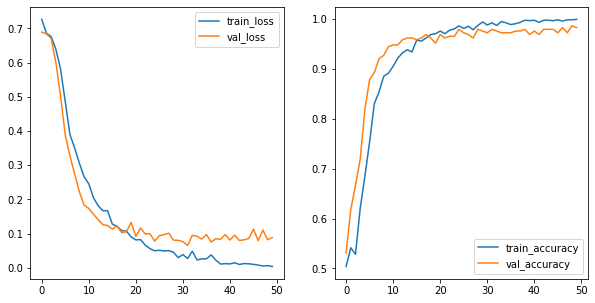

In [29]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=1,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [30]:
results.history['val_accuracy'][-1]

0.9826388955116272

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

2022-12-01 15:50:17.802018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-01 15:50:18.474947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2: early stopping


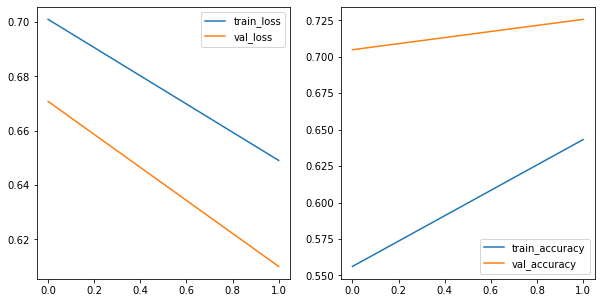

In [31]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

2022-12-01 15:51:42.075303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-01 15:51:42.825955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping


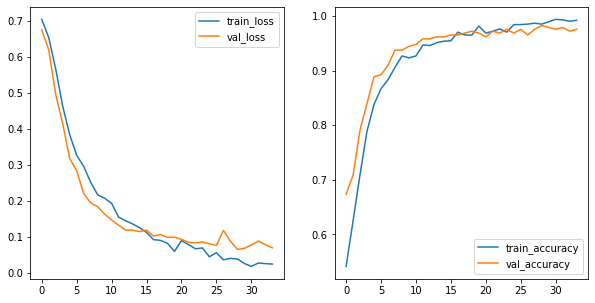

In [32]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [33]:
results.history['val_accuracy'][-1]

0.975694477558136

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [34]:
digits = load_digits()
X = digits.data
y = digits.target

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

In [41]:
y_test.reshape(-1,1)

array([[6],
       [9],
       [3],
       [7],
       [2],
       [1],
       [5],
       [2],
       [5],
       [2],
       [1],
       [9],
       [4],
       [0],
       [4],
       [2],
       [3],
       [7],
       [8],
       [8],
       [4],
       [3],
       [9],
       [7],
       [5],
       [6],
       [3],
       [5],
       [6],
       [3],
       [4],
       [9],
       [1],
       [4],
       [4],
       [6],
       [9],
       [4],
       [7],
       [6],
       [6],
       [9],
       [1],
       [3],
       [6],
       [1],
       [3],
       [0],
       [6],
       [5],
       [5],
       [1],
       [9],
       [5],
       [6],
       [0],
       [9],
       [0],
       [0],
       [1],
       [0],
       [4],
       [5],
       [2],
       [4],
       [5],
       [7],
       [0],
       [7],
       [5],
       [9],
       [5],
       [5],
       [4],
       [7],
       [0],
       [4],
       [5],
       [5],
       [9],
       [9],
       [0],
       [2],
    

For a multiclass output, our neural net expects our target to be in a certain form.

In [43]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [ ]:
9 = [0,0,0,0,0,0,0,0,1]

In [38]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
# Final layer will look different need a node for each class
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
 11/115 [=>............................] - ETA: 1s - loss: 2.2151 - accuracy: 0.1364

2022-12-01 16:09:15.530013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 2.1343 - accuracy: 0.1906

2022-12-01 16:09:16.961869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 2s 14ms/step - loss: 2.1343 - accuracy: 0.1906 - val_loss: 2.0313 - val_accuracy: 0.2951
Epoch 2/50
115/115 [==============================] - 2s 14ms/step - loss: 1.8537 - accuracy: 0.4151 - val_loss: 1.7728 - val_accuracy: 0.3854
Epoch 3/50
115/115 [==============================] - 1s 12ms/step - loss: 1.5734 - accuracy: 0.5109 - val_loss: 1.5190 - val_accuracy: 0.5000
Epoch 4/50
115/115 [==============================] - 1s 12ms/step - loss: 1.2880 - accuracy: 0.6223 - val_loss: 1.1931 - val_accuracy: 0.6806
Epoch 5/50
115/115 [==============================] - 1s 13ms/step - loss: 0.9685 - accuracy: 0.7755 - val_loss: 0.8816 - val_accuracy: 0.7778
Epoch 6/50
115/115 [==============================] - 1s 12ms/step - loss: 0.7471 - accuracy: 0.8303 - val_loss: 0.7085 - val_accuracy: 0.8368
Epoch 7/50
115/115 [==============================] - 2s 14ms/step - loss: 0.6138 - accuracy: 0.8460 - val_loss: 0.6152 - val_accuracy: 0.8438
Epoch 8/50

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [45]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

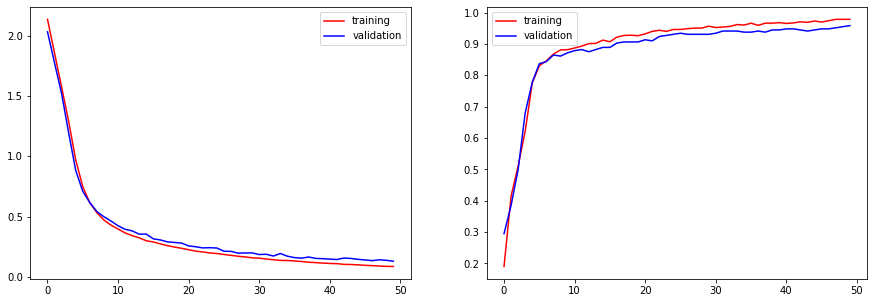

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [49]:
model.predict(X_test)

12/12 [==============================] - 0s 5ms/step


array([[1.52603377e-06, 8.26492013e-08, 1.96000077e-13, ...,
        2.43272013e-14, 8.26902851e-06, 7.07993468e-06],
       [1.62480155e-03, 1.82944689e-07, 4.39526844e-12, ...,
        5.56794112e-04, 1.24641796e-04, 7.63147354e-01],
       [9.20778905e-12, 1.12878351e-09, 4.48812825e-05, ...,
        8.83571716e-10, 2.97470455e-04, 1.81888259e-04],
       ...,
       [2.57750321e-06, 2.46330678e-01, 7.28052328e-07, ...,
        1.55613646e-01, 5.07173479e-01, 6.44274428e-02],
       [4.84675544e-09, 3.63406315e-07, 1.93736819e-03, ...,
        1.21103225e-08, 3.62342000e-02, 3.47636603e-02],
       [3.35510194e-05, 3.22171090e-09, 5.99028856e-13, ...,
        6.51897025e-09, 1.33959184e-05, 4.08401247e-03]], dtype=float32)

In [50]:
model.predict(X_test)[0]

12/12 [==============================] - 0s 2ms/step


array([1.5260338e-06, 8.2649201e-08, 1.9600008e-13, 6.8247903e-13,
       3.8098119e-06, 7.0647690e-07, 9.9997854e-01, 2.4327201e-14,
       8.2690285e-06, 7.0799347e-06], dtype=float32)

In [51]:
len(model.predict(X_test)[0])

12/12 [==============================] - 0s 6ms/step


10

In [52]:
model.predict(X_test)[0].sum()

12/12 [==============================] - 0s 4ms/step


1.0

In [69]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

12/12 [==============================] - 0s 2ms/step


In [70]:
y_hat_test

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 3, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 3, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 9, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 9, 7, 2, 6, 9, 4, 0, 7, 3, 7, 5, 8, 7, 5,
       7, 9, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 6, 5, 6, 6, 0,
       6, 4, 2, 9, 3, 7, 7, 2, 9, 0, 4, 5, 3, 6, 5, 7, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 1, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 9, 1, 4, 7, 6, 5, 8, 5,
       5, 1, 4, 1, 8, 8, 9, 5, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 8, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,

In [76]:
y_hat_test2 = np.argmax(model.predict(X_test), axis=1)

12/12 [==============================] - 0s 6ms/step


In [77]:
y_hat_test2

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 3, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 3, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 9, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 9, 7, 2, 6, 9, 4, 0, 7, 3, 7, 5, 8, 7, 5,
       7, 9, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 6, 5, 6, 6, 0,
       6, 4, 2, 9, 3, 7, 7, 2, 9, 0, 4, 5, 3, 6, 5, 7, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 1, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 9, 1, 4, 7, 6, 5, 8, 5,
       5, 1, 4, 1, 8, 8, 9, 5, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 8, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,

In [74]:
y_hat_test2 == y_hat_test

/var/folders/0c/wkrr_xjn2xz65fx41rj45h6w0000gp/T/ipykernel_11260/3789904300.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  y_hat_test2 == y_hat_test


False

In [56]:
y_test_restore = ohe.inverse_transform(y_test)
y_test_restore

array([[6],
       [9],
       [3],
       [7],
       [2],
       [1],
       [5],
       [2],
       [5],
       [2],
       [1],
       [9],
       [4],
       [0],
       [4],
       [2],
       [3],
       [7],
       [8],
       [8],
       [4],
       [3],
       [9],
       [7],
       [5],
       [6],
       [3],
       [5],
       [6],
       [3],
       [4],
       [9],
       [1],
       [4],
       [4],
       [6],
       [9],
       [4],
       [7],
       [6],
       [6],
       [9],
       [1],
       [3],
       [6],
       [1],
       [3],
       [0],
       [6],
       [5],
       [5],
       [1],
       [9],
       [5],
       [6],
       [0],
       [9],
       [0],
       [0],
       [1],
       [0],
       [4],
       [5],
       [2],
       [4],
       [5],
       [7],
       [0],
       [7],
       [5],
       [9],
       [5],
       [5],
       [4],
       [7],
       [0],
       [4],
       [5],
       [5],
       [9],
       [9],
       [0],
       [2],
    

In [57]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 27,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 29,  2,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  1, 32,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 44,  0,  0,  1,  2],
       [ 0,  0,  0,  0,  1,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  1,  0,  0,  0,  1,  0,  0, 27,  1],
       [ 0,  0,  0,  1,  0,  1,  0,  2,  1, 35]])

In [58]:
from sklearn.metrics import recall_score

In [60]:
recall_score(y_test_restore, y_hat_test, average='macro')

0.9437437083150476

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

